In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print('list of input files:\n* ',f)

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
data['c'] = np.copy(temp)[:,-1]

print('\ninput data has shape:\tx ',  data['x'].shape)
print('target data has shape:\tc ', data['c'].shape)
print()

list of input files:
*  ['full_speach_data.ssv']

input data has shape:	x  (990, 10)
target data has shape:	c  (990,)



In [4]:
# normalize data in the range [0,1]
data['nx'] = np.nan*np.empty(data['x'].shape)

for jj in range(data['x'].shape[1]):
    data['nx'][:,jj] = (data['x'][:,jj]-np.amin(data['x'][:,jj]))/(np.amax(data['x'][:,jj])-np.amin(data['x'][:,jj]))

if 0:
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    ax1.plot(data['nx'])

    plt.show()
    plt.close()

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'

setting = 0
if setting == 0:
    train['x'] = np.copy(data['nx'][:default[0],:])
    train['c'] = np.copy(data['c'][:default[0]])
    
    test['x']  = np.copy(data['nx'][-default[1]:,:])
    test['c']  = np.copy(data['c'][-default[1]:])
#elif setting == 1:

print('\ntrain set')    
print(train['x'].shape)
print(train['c'].shape)

print('\ntest set')
print(test['x'].shape)
print(test['c'].shape)


train set
(528, 10)
(528,)

test set
(462, 10)
(462,)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
c = Variable( torch.from_numpy(train['c']).long() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
c_test = Variable( torch.from_numpy(test['c']).long() )

In [7]:
### import UTILITY functions
from modules.graph_utils import *
    #
    # def show_graph(obj, string='loglog'):
    # def print_spec(obj):

### import NETWORK LOOPS functions
from modules.network_loops import *
    #
    # def run_training(obj, train_x, train_y, valid_x, valid_y):
    # def run_test(obj, test_x, test_y, verbose=True):

from modules.models import *
    #
    # class Baseline(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    # class BaseSigmoid(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    # class BestFitSigmoid(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    #
    # def generate_entry(obj, verbose = False):

# prints errors in semi-log axis
show_type = 'lin'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
### dimensions of 
# N is batch size
N     = train['x'].shape[0]
# D_in is input dimension
D_in  = train['x'].shape[1]
# H*n is the hidden layer dimension
H     = 11
n     = 8
# is the last hidden layer size
D_out = 11

# numer of epochs
epochs = int(4e3)

# save things to file?
save_to_file=True

In [9]:
##### model settings
k = 1e-2
base_lr = k*5e0
sigm_lr = k*12
best_lr = k*.65e-1
fitr_lr = k*1

base_mom = 0.35
sigm_mom = 0.25
best_mom = 0.5
fitr_mom = 0.0

In [10]:
# settings: '' name, H = width of hidden layers, n = number of hidden H-layers,
#           NL_out = nonlinear output layer/sum-only output layer,
#           'model'
#           'criterion' and parameters
#           'optimizer' and parameters

LL = []
for size in [[11,2], [11,3], [22,2], [22,3]]:
    for NL_type in [ ['base', base_lr, base_mom, False],
                      ['sigmoid', sigm_lr, sigm_mom, True],
                      ['bestfit', best_lr, best_mom, True],
                      ['fitrelu', fitr_lr, fitr_mom, True]
                    ]:
        LL.append(
            [['%s-%dx%d'%(NL_type[0], size[0], size[1]), N, D_in, size[0], size[1], D_out, False, epochs],
             NL_type[0],
             'CEL', [True],
             'SGD', [NL_type[1], NL_type[2]],
             'StepLR', [1000, 0.6]
            ]
        )

print(len(LL))

verb=False

16


In [11]:
# create empty dictionary {} and list []
models = {}
results = []

ii = 0 # choose the model
#ii = 4 # choose the model
#ii = 8 # choose the model
#ii = 12 # choose the model
rep = 4
for jj in range(rep): # number of repetitions
    models[jj] = generate_entry(LL[ii], verbose=verb)
    run_training(models[jj], x, c, x_test, c_test)
    results.append( max(models[jj][-3][:]) )
    print('%d\t%s\t%.2f%%'%(jj,models[jj][0][0],results[jj]) )


# # # # # # # # # # # # # #

epochs	error		validation
200 	2.39708 	2.39745 	9.09
400 	2.39344 	2.39439 	15.15
600 	2.37651 	2.38069 	9.31
800 	2.15969 	2.18921 	15.58
1000 	1.93051 	1.98475 	22.29
1200 	1.85911 	1.93178 	24.89
1400 	1.80510 	1.89486 	27.71
1600 	1.75725 	1.86267 	32.47
1800 	1.70597 	1.82860 	33.12
2000 	1.64787 	1.80278 	28.14
2200 	1.60587 	1.79272 	24.89
2400 	1.55445 	1.78912 	24.24
2600 	1.49679 	1.78897 	23.38
2800 	1.43124 	1.78967 	24.24
3000 	1.36335 	1.77578 	24.68
3200 	1.32458 	1.75953 	26.19
3400 	1.28904 	1.74453 	26.41
3600 	1.25582 	1.72969 	27.27
3800 	1.22363 	1.71504 	29.65
4000 	1.19185 	1.69876 	30.52
0	base-11x2	33.12%

# # # # # # # # # # # # # #

epochs	error		validation
200 	2.38634 	2.39065 	14.72
400 	2.27259 	2.30481 	12.34
600 	1.76449 	1.92757 	25.76
800 	1.48549 	1.86848 	32.47
1000 	1.25105 	1.88479 	38.31
1200 	1.13183 	2.05418 	34.20
1400 	1.05973 	2.23484 	32.90
1600 	1.01179 	2.35306 	33.77
1800 	0.99151 	2.40446 	33.33
2000 	1.025

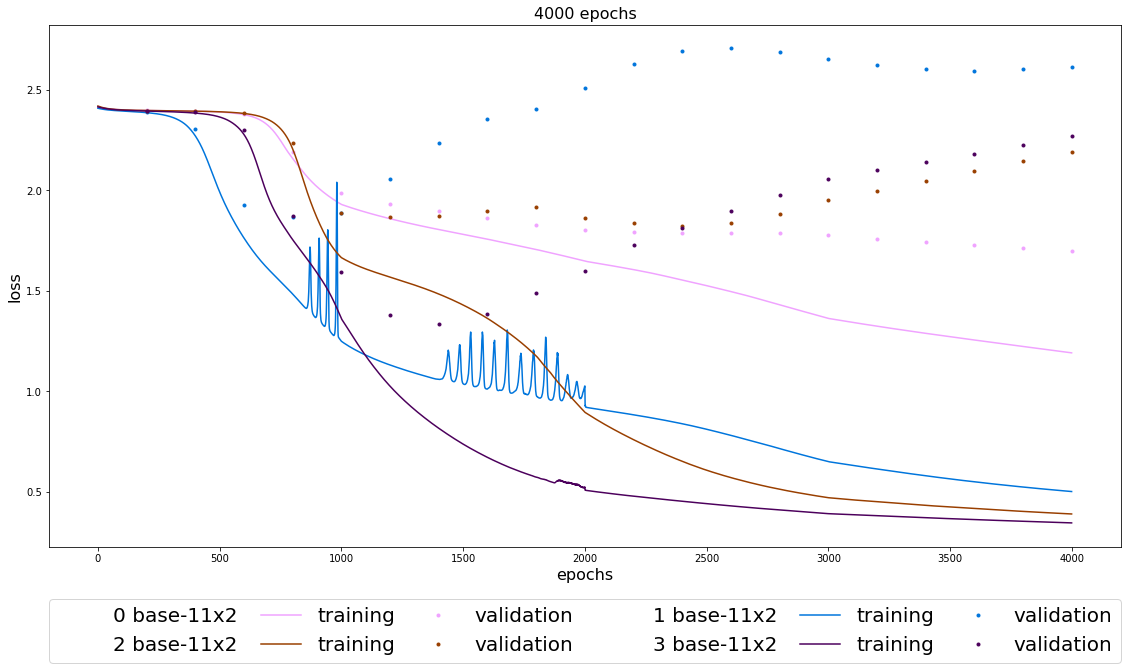

In [12]:
# show_graph(models, show_type)
fig, ax1, error, valid = show_graph(models, show_type)

if save_to_file:
    plt.savefig('data/'+models[ii][0][0]+'.png', format='png')

plt.show()
plt.close()

In [13]:
to_file = []
for ii,mm in models.items():
    print('%s\t%3.2f %%'%(models[ii][0][0], results[ii]))
    to_file.append( results[ii] )

total_string = '({:.2f} ± {:.2f})%'.format(np.average(results[:]),np.std(results[:]))
print('\n%s'%total_string )

if save_to_file:
    np.savetxt( 'data/'+models[ii][0][0]+'_overview.csv' , to_file, fmt='%3.2f', delimiter="\t", header=total_string)
    
del to_file

base-11x2	33.12 %
base-11x2	47.19 %
base-11x2	50.43 %
base-11x2	54.55 %

(46.32 ± 8.06)%


In [14]:
### save data to csv files
if save_to_file:
    x = np.linspace(1,epochs,epochs).reshape(epochs,1)
    print(x.shape)

    yy = models[0][-1][:]
    for jj in range(rep-1):
         yy = np.vstack( (yy, models[jj+1][-1][:]) )
    print( yy.T.shape )

    dat = np.concatenate( (x, yy.T), axis=1 )
    print(dat.shape)

    np.savetxt( 'data/'+models[ii][0][0]+'_learn.csv' , dat, fmt='%.5f', delimiter="\t")

    x = np.linspace(epochs//20,epochs,20).reshape(20,1)
    print(x.shape)

    yy = models[0][-2][:]
    for jj in range(rep-1):
         yy = np.vstack( (yy, models[jj+1][-2][:]) )
    print( yy.T.shape )

    dat = np.concatenate( (x, yy.T), axis=1 )
    print(dat.shape)

    np.savetxt( 'data/'+models[ii][0][0]+'_valid.csv' , dat, fmt='%.5f', delimiter="\t")

(4000, 1)
(4000, 4)
(4000, 5)
(20, 1)
(20, 4)
(20, 5)
